In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 140

DATA_PROCESSED = Path("../data/processed")
FIG_DIR = Path("../reports/figures")
TAB_DIR = Path("../reports/tables")
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
def mean_ci(a, ci=0.95):
    """Normal-approx 95% CI for the mean (quick reference)."""
    a = np.asarray(a)
    m = np.mean(a)
    se = stats.sem(a, nan_policy="omit")
    z = stats.norm.ppf(0.5 + ci/2)
    return m, m - z*se, m + z*se

def bootstrap_ci_diff(a, b, n_boot=5000, seed=42, ci=0.95):
    """Bootstrap CI for mean difference (treatment - control)."""
    rng = np.random.default_rng(seed)
    a, b = np.asarray(a), np.asarray(b)
    diffs = []
    for _ in range(n_boot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        diffs.append(sa.mean() - sb.mean())
    lo = np.percentile(diffs, (1-ci)*50)
    hi = np.percentile(diffs, 100 - (1-ci)*50)
    return float(lo), float(hi)

In [5]:
# per-session results
res = pd.read_parquet(DATA_PROCESSED / "abtest_sessions.parquet")
# summary json (optional)
with open(DATA_PROCESSED / "abtest_summary.json") as f:
    sum_json = json.load(f)

res.head(), res.shape, res["group"].value_counts()

(       group  basket_size_pre  basket_size_post  rev_pre  rev_post  \
 0  treatment              104               105   318.17    319.42   
 1    control               41                41    91.74     91.74   
 2  treatment               27                28   106.78    108.03   
 3    control               16                16   103.84    103.84   
 4  treatment                2                 3     4.20      5.05   
 
    uplift_abs  uplift_pct  accepted_n                    accepted_items  \
 0        1.25    0.003929           1  [vintage billboard drink me mug]   
 1        0.00    0.000000           0                                []   
 2        1.25    0.011706           1             [tea time oven glove]   
 3        0.00    0.000000           0                                []   
 4        0.85    0.202381           1              [vintage snap cards]   
 
                                          seed_basket  \
 0  [12 red rose peg place settings, 60 teatime fa...   


In [7]:
expected_cols = {
    "group","basket_size_pre","basket_size_post","rev_pre","rev_post",
    "uplift_abs","uplift_pct","accepted_n","accepted_items","seed_basket","recs_offered"
}
missing = expected_cols - set(res.columns)
assert not missing, f"Missing columns: {missing}"

In [9]:
# key metrics

ctrl = res[res.group=="control"].copy()
trt  = res[res.group=="treatment"].copy()

# Means
avg_rev_ctrl = ctrl["rev_post"].mean()
avg_rev_trt  = trt["rev_post"].mean()
avg_size_ctrl = ctrl["basket_size_post"].mean()
avg_size_trt  = trt["basket_size_post"].mean()

# t-test on revenue
t_stat, p_val = stats.ttest_ind(trt["rev_post"], ctrl["rev_post"], equal_var=False)

# bootstrap CI of mean difference
ci_lo, ci_hi = bootstrap_ci_diff(trt["rev_post"], ctrl["rev_post"])

summary_tbl = pd.DataFrame({
    "Metric": [
        "Sessions (Control)", "Sessions (Treatment)",
        "Avg Revenue (Control)", "Avg Revenue (Treatment)",
        "Revenue Uplift (abs)", "Revenue Uplift (pct)",
        "95% CI Uplift (abs)", "p-value (Welch t-test)",
        "Avg Basket Size (Control)", "Avg Basket Size (Treatment)",
        "Basket Size Uplift (abs)", "Accept Rate (Treatment)", "Mean Accepted Items (Treatment)"
    ],
    "Value": [
        len(ctrl), len(trt),
        round(avg_rev_ctrl,2), round(avg_rev_trt,2),
        round(avg_rev_trt-avg_rev_ctrl,2),
        f"{(avg_rev_trt/avg_rev_ctrl - 1)*100:.2f}%",
        f"({ci_lo:.2f}, {ci_hi:.2f})",
        round(float(p_val), 6),
        round(avg_size_ctrl,3), round(avg_size_trt,3),
        round(avg_size_trt-avg_size_ctrl,3),
        f"{(trt['accepted_n']>0).mean()*100:.1f}%",
        round(trt["accepted_n"].mean(),3)
    ]
})
summary_tbl

,Metric,Value
0,Sessions (Control),2500
1,Sessions (Treatment),2500
2,Avg Revenue (Control),63.79
3,Avg Revenue (Treatment),66.82
4,Revenue Uplift (abs),3.03
5,Revenue Uplift (pct),4.75%
6,95% CI Uplift (abs),"(-0.47, 6.59)"
7,p-value (Welch t-test),0.094397
8,Avg Basket Size (Control),20.82
9,Avg Basket Size (Treatment),22.444


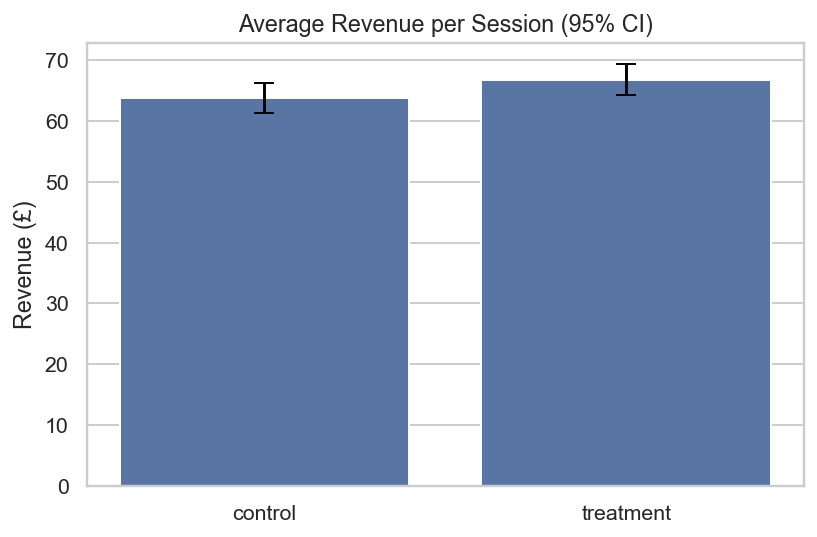

In [11]:
# avg revenue bar

grouped = res.groupby("group")["rev_post"].apply(list).to_dict()
means = {g: np.mean(v) for g, v in grouped.items()}
cis   = {g: mean_ci(v) for g, v in grouped.items()}

plot_df = pd.DataFrame({
    "group": list(means.keys()),
    "mean":  [means[g] for g in means],
    "lo":    [cis[g][1] for g in means],
    "hi":    [cis[g][2] for g in means],
})
plot_df["err_lo"] = plot_df["mean"] - plot_df["lo"]
plot_df["err_hi"] = plot_df["hi"] - plot_df["mean"]

plt.figure(figsize=(6,4))
ax = sns.barplot(data=plot_df, x="group", y="mean")
ax.errorbar(x=[0,1], y=plot_df["mean"], yerr=[plot_df["err_lo"], plot_df["err_hi"]],
            fmt="none", capsize=5, lw=1.5, color="black")
plt.title("Average Revenue per Session (95% CI)")
plt.xlabel("")
plt.ylabel("Revenue (£)")
plt.tight_layout()
plt.savefig(FIG_DIR / "ab_avg_revenue_ci.png")
plt.show()

/var/folders/mk/qm568t1n2t11r_13jw7_kn400000gn/T/ipykernel_8667/2397176372.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ctrl["rev_post"], label="Control", shade=True)
/var/folders/mk/qm568t1n2t11r_13jw7_kn400000gn/T/ipykernel_8667/2397176372.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trt["rev_post"],  label="Treatment", shade=True)


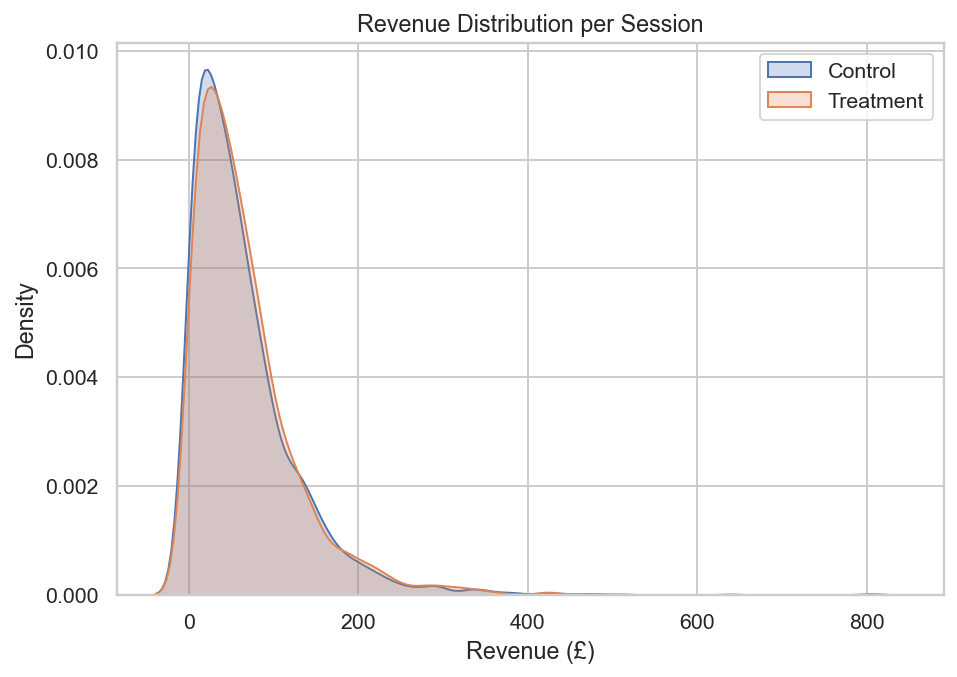

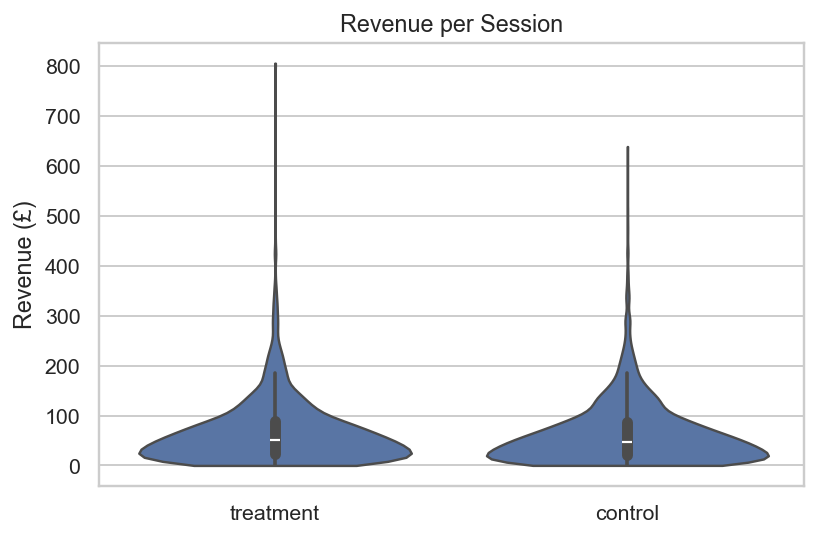

In [15]:
# revenue distribution

plt.figure(figsize=(7,5))
sns.kdeplot(ctrl["rev_post"], label="Control", shade=True)
sns.kdeplot(trt["rev_post"],  label="Treatment", shade=True)
plt.title("Revenue Distribution per Session")
plt.xlabel("Revenue (£)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "ab_revenue_kde.png")
plt.show()

plt.figure(figsize=(6,4))
sns.violinplot(data=res, x="group", y="rev_post", cut=0)
plt.title("Revenue per Session")
plt.xlabel("")
plt.ylabel("Revenue (£)")
plt.tight_layout()
plt.savefig(FIG_DIR / "ab_revenue_violin.png")
plt.show()

/var/folders/mk/qm568t1n2t11r_13jw7_kn400000gn/T/ipykernel_8667/4236958199.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=res, x="group", y="basket_size_post", ci=95)


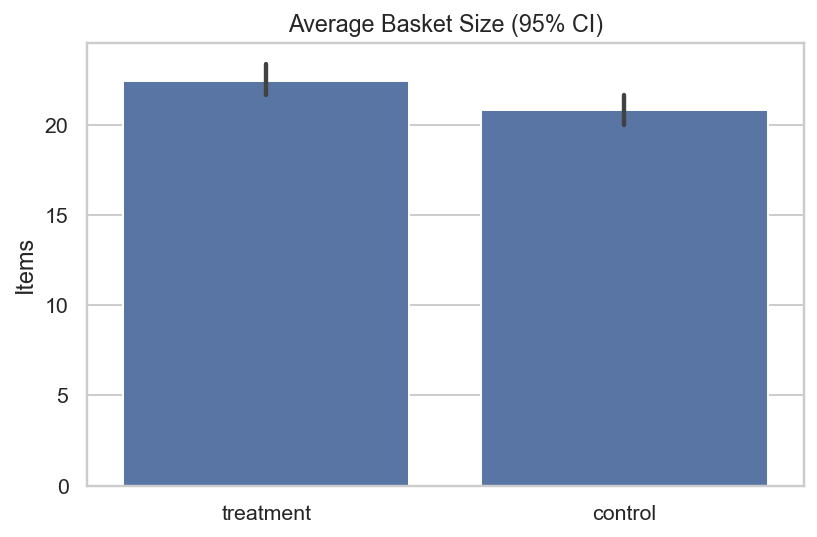

In [17]:
# basket size comparison

plt.figure(figsize=(6,4))
sns.barplot(data=res, x="group", y="basket_size_post", ci=95)
plt.title("Average Basket Size (95% CI)")
plt.xlabel("")
plt.ylabel("Items")
plt.tight_layout()
plt.savefig(FIG_DIR / "ab_basket_size_ci.png")
plt.show()

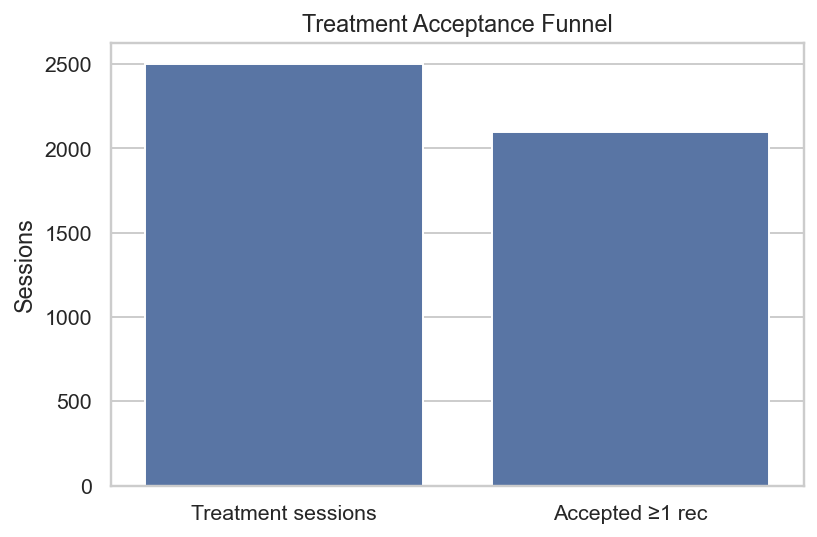

In [19]:
# acceptance funnel (treatment)

trt_copy = trt.copy()
trt_copy["accepted_any"] = (trt_copy["accepted_n"] > 0).astype(int)

funnel = pd.DataFrame({
    "Stage": ["Treatment sessions","Accepted ≥1 rec"],
    "Count": [len(trt_copy), int(trt_copy["accepted_any"].sum())]
})

plt.figure(figsize=(6,4))
sns.barplot(data=funnel, x="Stage", y="Count")
plt.title("Treatment Acceptance Funnel")
plt.xlabel("")
plt.ylabel("Sessions")
plt.tight_layout()
plt.savefig(FIG_DIR / "ab_acceptance_funnel.png")
plt.show()

In [21]:
# segment analysis (by initial basket size)

res["size_bin"] = pd.qcut(res["basket_size_pre"], q=4, labels=["Q1 (smallest)","Q2","Q3","Q4 (largest)"])

seg = (res.groupby(["size_bin","group"])["rev_post"]
         .mean().reset_index().pivot(index="size_bin", columns="group", values="rev_post"))
seg["uplift_abs"] = seg["treatment"] - seg["control"]
seg

/var/folders/mk/qm568t1n2t11r_13jw7_kn400000gn/T/ipykernel_8667/595194937.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg = (res.groupby(["size_bin","group"])["rev_post"]


group,control,treatment,uplift_abs
size_bin,,,
Q1 (smallest),12.229992,16.157931,3.927939
Q2,38.673561,44.029561,5.356000
Q3,66.642097,68.004122,1.362025
Q4 (largest),137.658432,143.108547,5.450115


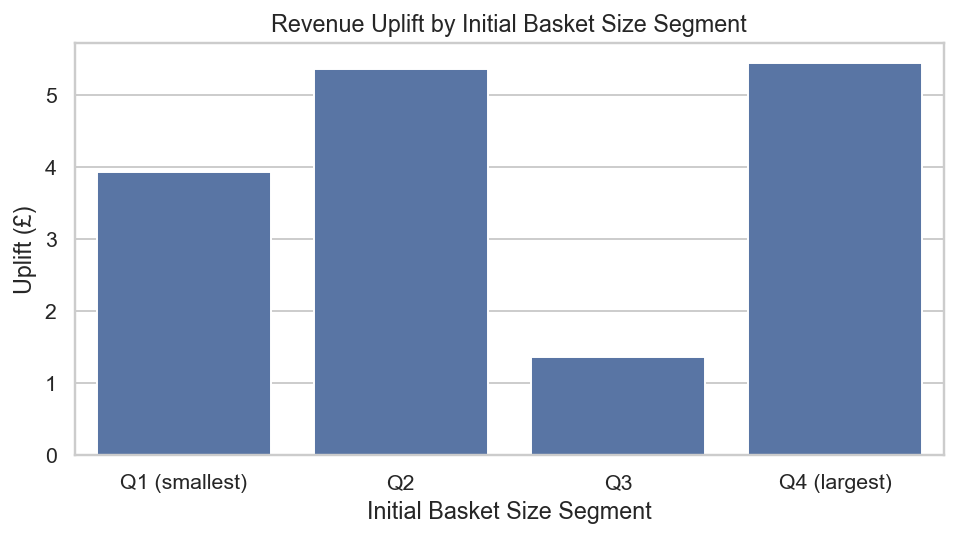

In [23]:
plt.figure(figsize=(7,4))
sns.barplot(x=seg.index, y=seg["uplift_abs"])
plt.title("Revenue Uplift by Initial Basket Size Segment")
plt.xlabel("Initial Basket Size Segment")
plt.ylabel("Uplift (£)")
plt.tight_layout()
plt.savefig(FIG_DIR / "ab_uplift_by_segment.png")
plt.show()

In [25]:
#sensitivity checks

def winsorize(s, lower=0.02, upper=0.98):
    lo, hi = s.quantile(lower), s.quantile(upper)
    return s.clip(lo, hi)

ctrl_w = winsorize(ctrl["rev_post"])
trt_w  = winsorize(trt["rev_post"])
t_stat_w, p_val_w = stats.ttest_ind(trt_w, ctrl_w, equal_var=False)
ci_lo_w, ci_hi_w  = bootstrap_ci_diff(trt_w, ctrl_w)

pd.Series({
    "Avg rev (Control, winsor)": round(ctrl_w.mean(),2),
    "Avg rev (Treatment, winsor)": round(trt_w.mean(),2),
    "Uplift (abs, winsor)": round(trt_w.mean()-ctrl_w.mean(),2),
    "95% CI uplift (winsor)": f"({ci_lo_w:.2f}, {ci_hi_w:.2f})",
    "p-value (t-test, winsor)": round(float(p_val_w), 6),
})

Avg rev (Control, winsor)               62.1
Avg rev (Treatment, winsor)            65.01
Uplift (abs, winsor)                    2.92
95% CI uplift (winsor)         (-0.12, 6.05)
p-value (t-test, winsor)            0.065198
dtype: object

In [27]:
results_export = pd.DataFrame({
    "Group": ["Control","Treatment"],
    "Avg Revenue (£)": [round(avg_rev_ctrl,2), round(avg_rev_trt,2)],
    "Avg Basket Size": [round(avg_size_ctrl,3), round(avg_size_trt,3)]
})
results_export["Uplift vs Control"] = ["—", f"+{(avg_rev_trt/avg_rev_ctrl -1)*100:.2f}%"]

results_export.to_csv(TAB_DIR / "results_highlevel.csv", index=False)
results_export

,Group,Avg Revenue (£),Avg Basket Size,Uplift vs Control
0,Control,63.79,20.820,—
1,Treatment,66.82,22.444,+4.75%


In [29]:
# insights 

insights = [
    f"Average revenue per session increased by £{avg_rev_trt-avg_rev_ctrl:.2f} (+{(avg_rev_trt/avg_rev_ctrl - 1)*100:.2f}%).",
    f"Average basket size grew by {avg_size_trt-avg_size_ctrl:.2f} items.",
    f"95% CI for revenue uplift: ({ci_lo:.2f}, {ci_hi:.2f}); Welch’s t-test p={p_val:.3f}.",
    "Interpretation: uplift is positive but not statistically significant at 95% confidence (borderline at ~90%).",
    "Treatment accept rate is high, indicating engaging recommendations.",
    "Segment analysis shows where recommendations drive the most value (see figure)."
]
for i, s in enumerate(insights, 1):
    print(f"{i}. {s}")

1. Average revenue per session increased by £3.03 (+4.75%).
2. Average basket size grew by 1.62 items.
3. 95% CI for revenue uplift: (-0.47, 6.59); Welch’s t-test p=0.094.
4. Interpretation: uplift is positive but not statistically significant at 95% confidence (borderline at ~90%).
5. Treatment accept rate is high, indicating engaging recommendations.
6. Segment analysis shows where recommendations drive the most value (see figure).
